## Different Classifier Models: Practicality, Performance and Use Cases
 
**Data** [Sources](2_Data_Sources.ipynb) | [Compositional Data](2_Data_CompositionalData.ipynb) | [Lambdas](2_Data_Lambdas.ipynb) **Classifiers** [Models](3_Classifiers_ClassifierModels.ipynb) | [Dimensionality](3_Classifiers_Dimensionality.ipynb) | [Performance](3_Classifiers_Performance.ipynb) **Visualisation**  [Entropy](4_Vis_Entropy.ipynb) | [Manifolds](4_Vis_Manifolds.ipynb) **Workflows** [Building Workflows](5_BuildingWorkflows.ipynb) **pyrolite** [Overview](6_pyrolite.ipynb) **GitHub** [AEGC2019](https://github.com/morganjwilliams/aegc2019) | [pyrolite](https://github.com/morganjwilliams/pyrolite)

This notebook introduces some of the classifier models which have been used previously for geochemical tectonic discrimination, and provides minimal working examples for building a working model. For the purpose of developing classification models for tectonic discrimination using bulk-rock geochemical data, Petrelli et al. (2016) use Support Vector Classifiers ([Petrelli2016]), and Ueki et al. (2018) use Support Vector Classifiers, Random Forests and Sparse Multinomial Regression ([Ueki2018]). 

[Petrelli2016]: https://doi.org/10.1007/s00410-016-1292-2 "Petrelli, M., Perugini, D., 2016. Solving petrological problems through machine learning: the study case of tectonic discrimination using geochemical and isotopic data. Contrib Mineral Petrol 171, 81."
[Ueki2018]: https://doi.org/10.1029/2017GC007401 "Ueki, K., Hino, H., Kuwatani, T., 2018. Geochemical Discrimination and Characteristics of Magmatic Tectonic Settings: A Machine-Learning-Based Approach. Geochemistry, Geophysics, Geosystems 19, 1327–1347."

In [1]:
%matplotlib inline
import sys, os
import timeit
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# could also use imblearn.pipleline.make_pipeline

In [3]:
from pyrolite.geochem.ind import common_elements, common_oxides

from pyrolite.util.skl.vis import plot_confusion_matrix
from pyrolite.util.skl.pipeline import SVC_pipeline, PdUnion
from pyrolite.util.skl.select import CompositionalSelector
from pyrolite.util.skl.transform import CLRTransform, LinearTransform

Using TensorFlow backend.


In [4]:
df = pd.read_csv('https://storage.googleapis.com/aegc2019/ueki2018.csv')

compositional_variables = common_elements(as_set=True) | common_oxides(as_set=True)
abundances = [i for i in df.columns if i in compositional_variables]
isotopes = [i for i in df.columns if i != "Class" and i not in compositional_variables]

classes = list(df.Class.unique())
classes

['CA', 'IA', 'IOA', 'BAB', 'CFB', 'MOR', 'OP', 'OI']

In [ ]:
X, y = df.loc[:, abundances + isotopes], df["Class"]

In [ ]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.3)

### Support Vector Classifiers

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
svcscore = clf.score(X_test, y_test)
svcscore

0.8780096308186196

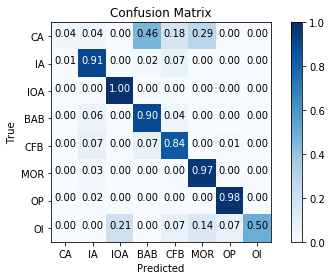

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, normalize=True, classes=classes)

### Random Forests

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=4, verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
rfscore = rf.score(X_test, y_test)
rfscore

In [ ]:
plot_confusion_matrix(rf, X_test, y_test, normalize=True, classes=classes)

In [ ]:
ft_importances = pd.DataFrame(data=np.round(rf.feature_importances_,3), 
                              columns=['Importance'], index=X.columns
                             ).sort_values('Importance', ascending=False) * 100
ft_importances[:6]

### Multinomial Logistic Regressions

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr.fit(X_train, y_train)

In [ ]:
lrscore = lr.score(X_test, y_test)
lrscore

In [ ]:
plot_confusion_matrix(lr, X_test, y_test, normalize=True, classes=classes)

In [ ]:
probs = pd.DataFrame(data=lr.predict_proba(X_test[:8, :]), columns=lr.classes_) * 100
probs["Expect"] = y_test[:8].tolist()
table = probs[probs.columns[::-1]].round(2)
table.style.background_gradient(cmap="Blues", axis=1)

### An Extended Workflow for Support Vector Classifiers: Gridsearch for Parameter Optimisation

In [ ]:
preprocessor = PdUnion(
    [
        make_pipeline(CompositionalSelector(), CLRTransform()),
        make_pipeline(CompositionalSelector(inverse=True), LinearTransform()),
    ]
)
XX_ = StandardScaler().fit_transform(preprocessor.fit_transform(X))

In [ ]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX_, y, stratify=y, test_size=0.3)

In [ ]:
params = dict(
    verbose=1,
    probability=True,  # Use Platt scaling to give estimates of probabilistic output
    param_grid=dict(
        svc__gamma=np.logspace(-2.3, -0.85, 5),
        svc__C=np.logspace(-0.5, 2, 5),  # limit C parameter to avoid overfitting
    ),
)

In [ ]:
gs = SVC_pipeline(**params)
gs.fit(XX_train, yy_train)

In [ ]:
svc2score = gs.best_estimator_.score(XX_test, yy_test)
svc2score

In [ ]:
plot_confusion_matrix(
    gs.best_estimator_, XX_test, yy_test, normalize=True, classes=classes
) 

In [ ]:
probs = (
    pd.DataFrame(
        data=gs.best_estimator_.predict_proba(XX_test[:8]),
        columns=gs.best_estimator_.classes_,
    )
    * 100
)
probs["Expect"] = yy_test[:8].tolist()
table = probs[probs.columns[::-1]].round(2)
table.style.background_gradient(cmap="Blues", axis=1)

In [ ]:
lr2 = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr2.fit(XX_train, yy_train)
lr2score = lr2.score(XX_test, yy_test) 

In [ ]:
rf2 = RandomForestClassifier()
rf2.fit(XX_train, yy_train)
rf2score = rf2.score(XX_test, yy_test)

In [ ]:
results = pd.DataFrame(data = [(svcscore, svc2score), 
                               (rfscore, rf2score), 
                               (lrscore, lr2score)], 
                       columns=['Start', "With CLR"], 
                       index = ['SVC', 'RandomForest', 'Logist.Reg.']
                      ).round(3) *100
results.style.format(lambda x: "{:.1f}%".format(x)).background_gradient(cmap="Greens",low=0, high=1, axis=None)